In [1]:
import numpy as np
import matplotlib.pyplot as plt
import fitsio
from astropy.table import Table
from GetObjects import *

In [2]:
from ugali.analysis.isochrone import factory as isochrone_factory
from matplotlib.path import Path
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

def mkpol(mu, age=12., z=0.0004, dmu=0.5, C=[0.05, 0.05], E=4., err=None, survey='DECaLS', clip=None):
    if err == None:
        print('Using DES err!')
        err = surveys.surveys['DES_DR1']['err']
    """ Builds ordered polygon for masking """

    iso = isochrone_factory('Bressan2012', survey='des',
                            age=age, distance_modulus=mu, z=z)
    c = iso.color
    m = iso.mag

    # clip=4
    # clip = 3.4
    if clip is not None:
        # Clip for plotting, use gmin otherwise
        # clip abs mag
        cut = (m > clip) & ((m + mu) < 240) & (c > 0) & (c < 1)
        c = c[cut]
        m = m[cut]

    mnear = m + mu - dmu / 2.
    mfar = m + mu + dmu / 2.
    C = np.r_[c + E * err(mfar) + C[1], c[::-1] -  E * err(mnear[::-1]) - C[0]]
    M = np.r_[m, m[::-1]]
    return np.c_[C, M],iso
err=lambda x: (0.0010908679647672335 + np.exp((x - 27.091072029215375) / 1.0904624484538419))

def feh2z( feh):
        # Section 3 of Dotter et al. 2008
        Y_p     = 0.245            # Primordial He abundance (WMAP, 2003)
        c       = 1.54             # He enrichment ratio 

        # This is not well defined...
        #Z_solar/X_solar = 0.0229  # Solar metal fraction (Grevesse 1998)
        ZX_solar = 0.0229
        return (1 - Y_p)/( (1 + c) + (1/ZX_solar) * 10**(-feh))
    
def dist_fu(ra):
    # given ra in deg return distance of 300s in kpc from fu et al.  
    return 48.9952-0.2083*ra

def dist2mod(dist):
    return np.log10(dist*1e3)*5-5

In [3]:
gCut = 27
detBalrStarFile = '/afs/hep.wisc.edu/bechtol-group/MegansThings/balrog_detection_catalog_sof_run2_stars_v1.4_avg_added_match_flags.fits'
detStarFile = '/hdfs/bechtol/balrog/y3/y3a2_survey_conditions_maps/Kyle_Stuff/MaximumLikelihood/StellarStreamFirstTest/BalrogData.fits'

mu = 16.2
age=12.8
feh=-2.5
z=feh2z(feh)
mk,iso=mkpol(mu,age,z,dmu=0.5,C=[0.01,0.1],E=2,err=err, survey="DES_Y3A2")#, clip=0.3)
pth=Path(mk)

getDetStar(pth, mu, detBalrStarFile, detStarFile, gCut)

In [4]:
data = fitsio.read(detStarFile)
RMAG = data['RMAG']
DET = data['DETECTED']
CLASS = data['CLASS']

In [5]:
sigma = 0.5
numBins = 100

In [6]:
x = np.linspace(np.average(RMAG)-3*np.std(RMAG), np.average(RMAG)+3*np.std(RMAG), numBins)
x = x[np.where(x <= np.max(RMAG))[0]]
detStarSigma = sigma * np.std(RMAG)
y = []

for xi in x:
    # Gaussian weighting the values close by to each x value.
    totCor = np.sum(DET * np.exp(-1*(((RMAG - xi) / detStarSigma)**2)))
    totAll = np.sum(np.exp(-1*(((RMAG - xi) / detStarSigma)**2)))
    y.append(totCor / totAll)

y = np.array(y)

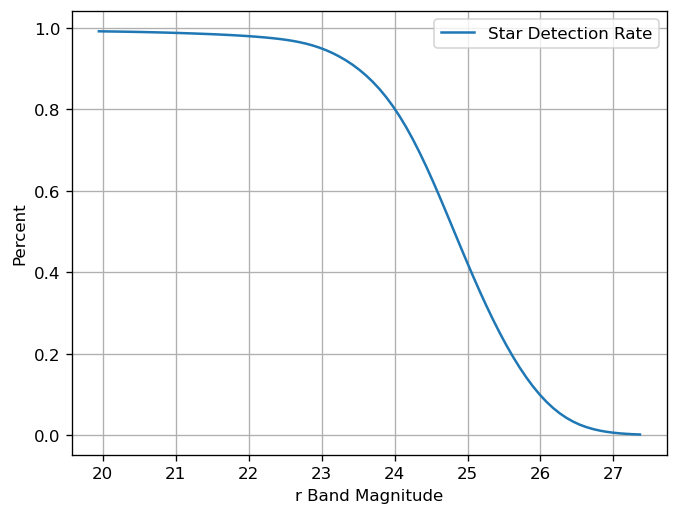

In [7]:
plt.figure(dpi = 120)
plt.plot(x, y, zorder = 3, label = 'Star Detection Rate')
plt.xlabel('r Band Magnitude')
plt.ylabel('Percent')
plt.legend()
plt.grid(zorder = 0)
# plt.ylim([0, 1])
plt.show()

In [12]:
np.min(CLASS[np.where(DET == 1)[0]])

-9

In [13]:
len(np.where(CLASS == -9)[0]) / np.sum(DET)

0.013243598849597709